# CASE STUDY – CREDIT CARD
# SEGMENTATION

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA   
import sklearn.metrics as metrics

## Importing data

In [181]:
cc_seg=pd.read_csv('CC_GENERAL.csv')

In [182]:
cc_seg.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [183]:
cc_seg=cc_seg.drop(['CUST_ID'],axis=1) # Dropping ID columns
numeric_var_names=[key for key in dict(cc_seg.dtypes) if dict(cc_seg.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(cc_seg.dtypes) if dict(cc_seg.dtypes)[key] in ['object']]


# Derived columns 

In [184]:
cc_num=cc_seg[numeric_var_names]
cc_num['Monthly_avg_purchase'] = cc_num['PURCHASES'] / cc_num['TENURE']
cc_num['Monthly_cash_advance'] = cc_num['CASH_ADVANCE'] / cc_num['TENURE']
cc_num['limit_usage'] = cc_num['BALANCE'] / cc_num['CREDIT_LIMIT']
cc_cat['purchase_type'] = np.where((cc_num['ONEOFF_PURCHASES'] == 0) & (cc_num['INSTALLMENTS_PURCHASES'] == 0), 'None',
                                  np.where((cc_num['ONEOFF_PURCHASES'] > 0) & (cc_num['INSTALLMENTS_PURCHASES'] == 0), 'One_Of', 
                                          np.where((cc_num['ONEOFF_PURCHASES'] == 0) & (cc_num['INSTALLMENTS_PURCHASES'] > 0), 'Installment_Purchases','Both')))


In [185]:
cc_cat.head(5)

,purchase_type
0,Installment_Purchases
1,None
2,One_Of
3,One_Of
4,One_Of


## Data Audit

In [186]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=cc_num.apply(lambda x: var_summary(x)).T
num_summary.to_csv('num_sum.csv')
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.400205e+07,1564.474828,873.385231,2081.531879,4.332775e+06,0.000000,0.065101,8.814518,23.575529,128.281915,873.385231,2054.140036,4338.563657,5909.111808,9338.804814,19043.138560
BALANCE_FREQUENCY,8950.0,0.0,7.851573e+03,0.877271,1.000000,0.236904,5.612351e-02,0.000000,0.090909,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PURCHASES,8950.0,0.0,8.978683e+06,1003.204834,361.280000,2136.634782,4.565208e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3998.619500,8977.290000,49039.570000
ONEOFF_PURCHASES,8950.0,0.0,5.302314e+06,592.437371,38.000000,1659.887917,2.755228e+06,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2671.094000,6689.898200,40761.250000
INSTALLMENTS_PURCHASES,8950.0,0.0,3.679055e+06,411.067645,89.000000,904.338115,8.178274e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1750.087500,3886.240500,22500.000000
CASH_ADVANCE,8950.0,0.0,8.760896e+06,978.871112,0.000000,2097.163877,4.398096e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4647.169122,9588.163357,47137.211760
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.000000
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.209541e+03,0.135144,0.000000,0.200121,4.004857e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.833333,1.500000


## Data Handling

In [187]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.95))
    x = x.clip(lower=x.quantile(0.05))
    return x

cc_num=cc_num.apply(lambda x: outlier_capping(x))

In [188]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

cc_num=cc_num.apply(lambda x: Missing_imputation(x))
cc_num.to_csv('Analysis_Data.csv')

## Correlation

In [189]:
corr_mat = cc_num.corr()
corr_mat.to_csv('Correlation.csv')
corr_mat

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Monthly_cash_advance,limit_usage
BALANCE,1.000000,0.370254,0.124336,0.138493,0.040367,0.565401,-0.102891,0.070789,-0.089514,0.489843,0.487851,0.086826,0.510508,0.347819,0.768634,-0.359881,0.075801,0.118802,0.543382,0.619551
BALANCE_FREQUENCY,0.370254,1.000000,0.192937,0.153188,0.170524,0.116485,0.237081,0.204411,0.184918,0.200011,0.178447,0.240389,0.105444,0.124358,0.263944,-0.111917,0.133089,0.187511,0.103147,0.456759
PURCHASES,0.124336,0.192937,1.000000,0.865282,0.710001,-0.137265,0.589131,0.658719,0.461632,-0.187429,-0.149599,0.802715,0.348444,0.515077,0.104749,0.215231,0.121018,0.994094,-0.143318,-0.113896
ONEOFF_PURCHASES,0.138493,0.153188,0.865282,1.000000,0.319737,-0.092469,0.394927,0.764991,0.168362,-0.121483,-0.096036,0.638903,0.336683,0.456999,0.059931,0.127898,0.087760,0.863161,-0.097293,-0.078629
INSTALLMENTS_PURCHASES,0.040367,0.170524,0.710001,0.319737,1.000000,-0.147078,0.639240,0.251237,0.729578,-0.200741,-0.162689,0.714152,0.210121,0.338280,0.101526,0.238894,0.116144,0.702986,-0.152415,-0.122449
CASH_ADVANCE,0.565401,0.116485,-0.137265,-0.092469,-0.147078,1.000000,-0.286882,-0.122090,-0.238361,0.739399,0.766841,-0.163455,0.307874,0.375003,0.396443,-0.211834,-0.097117,-0.134462,0.989460,0.303489
PURCHASES_FREQUENCY,-0.102891,0.237081,0.589131,0.394927,0.639240,-0.286882,1.000000,0.501343,0.862934,-0.333006,-0.282215,0.742413,0.115846,0.146167,-0.028759,0.305802,0.069300,0.589490,-0.288386,-0.227201
ONEOFF_PURCHASES_FREQUENCY,0.070789,0.204411,0.658719,0.764991,0.251237,-0.122090,0.501343,1.000000,0.142329,-0.125492,-0.106483,0.638118,0.298730,0.316838,-0.001163,0.157531,0.087045,0.656923,-0.124294,-0.096479
PURCHASES_INSTALLMENTS_FREQUENCY,-0.089514,0.184918,0.461632,0.168362,0.729578,-0.238361,0.862934,0.142329,1.000000,-0.282139,-0.237355,0.667528,0.054004,0.110787,0.002160,0.250087,0.079282,0.457713,-0.240906,-0.185039
CASH_ADVANCE_FREQUENCY,0.489843,0.200011,-0.187429,-0.121483,-0.200741,0.739399,-0.333006,-0.125492,-0.282139,1.000000,0.914309,-0.193915,0.134665,0.214712,0.326773,-0.267346,-0.127201,-0.182080,0.740138,0.422822


<AxesSubplot:>

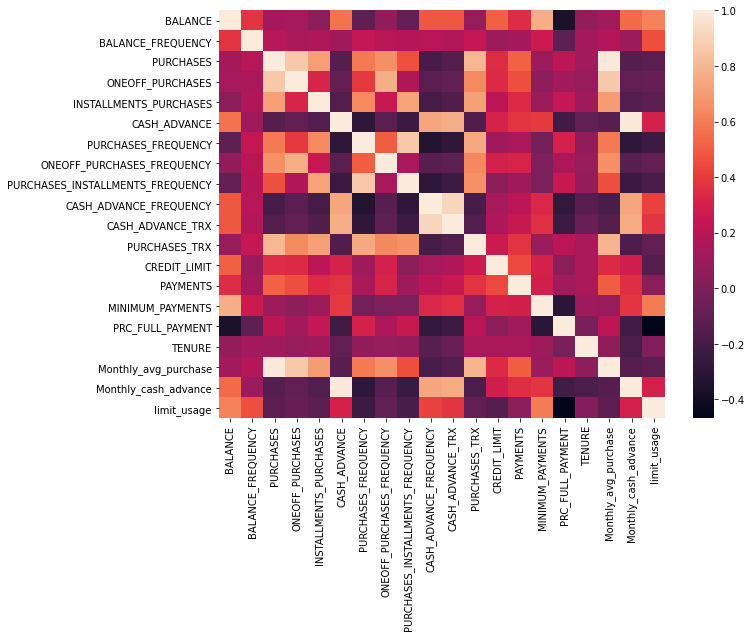

In [190]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(corr_mat)

In [191]:
cc_final = pd.concat([cc_num, cc_cat], axis=1)

### Creating dummy variables

In [192]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=False)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [193]:
dummy_cols = ['purchase_type']
for colname in dummy_cols:
    cc_final = create_dummies(cc_final, dummy_cols)

In [194]:
cc_final.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Monthly_cash_advance,limit_usage,purchase_type_Both,purchase_type_Installment_Purchases,purchase_type_None,purchase_type_One_Of
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,139.509787,0.000000,12,7.950000,0.000000,0.040901,0,1,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,1072.340217,0.222222,12,0.000000,425.548562,0.457495,0,0,1,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,627.284787,0.000000,12,64.430833,0.000000,0.332687,0,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,643.387510,0.000000,12,124.916667,17.149001,0.222223,0,0,0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,244.791237,0.000000,12,1.333333,0.000000,0.681429,0,0,0,1


### Standardrizing data 
- To put data on the same scale 

In [195]:
cc_final.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'Monthly_avg_purchase', 'Monthly_cash_advance', 'limit_usage',
       'purchase_type_Both', 'purchase_type_Installment_Purchases',
       'purchase_type_None', 'purchase_type_One_Of'],
      dtype='object')

In [196]:
sc=StandardScaler()

In [197]:
cc_scaled=sc.fit_transform(cc_final)

In [198]:
pd.DataFrame(cc_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.835783,-0.297904,-0.662389,-0.600394,-0.483999,-0.605707,-0.806490,-0.678661,-0.707313,-0.722502,...,-0.704768,-0.525551,0.378995,-0.672440,-0.600126,-0.990035,-0.670193,1.720516,-0.543690,-0.514625
1,1.036257,0.118296,-0.749136,-0.600394,-0.675642,2.838929,-1.221758,-0.678661,-0.916995,0.692644,...,0.599971,0.234227,0.378995,-0.757187,2.868023,0.212119,-0.670193,-0.581221,1.839282,-0.514625
2,0.617437,0.534496,-0.046095,0.435900,-0.675642,-0.605707,1.269843,2.673451,-0.916995,-0.722502,...,-0.022523,-0.525551,0.378995,-0.070357,-0.600126,-0.148038,-0.670193,-0.581221,-0.543690,1.943162
3,0.126875,-1.130304,0.613899,1.408742,-0.675642,-0.453170,-1.014125,-0.399319,-0.916995,-0.250789,...,0.000000,-0.525551,0.378995,0.574420,-0.460364,-0.466800,-0.670193,-0.581221,-0.543690,1.943162
4,-0.375812,0.534496,-0.734587,-0.578948,-0.675642,-0.605707,-1.014125,-0.399319,-0.916995,-0.722502,...,-0.557512,-0.525551,0.378995,-0.742974,-0.600126,0.858316,-0.670193,-0.581221,-0.543690,1.943162


### Applyting PCA

In [199]:
pc = PCA(n_components=23)

In [200]:
pc.fit(cc_scaled)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [201]:
pc.explained_variance_

array([7.02717807e+00, 5.14870910e+00, 2.31666137e+00, 1.74599688e+00,
       1.27242226e+00, 1.15989209e+00, 9.01652044e-01, 8.23597968e-01,
       7.21209285e-01, 5.34163253e-01, 4.62468622e-01, 4.36731734e-01,
       3.47240851e-01, 3.11485350e-01, 2.11637771e-01, 1.82730654e-01,
       1.38511799e-01, 1.06931567e-01, 7.58981207e-02, 4.17232393e-02,
       2.53948694e-02, 7.03305693e-03, 3.41192543e-03])

In [202]:
#Eigen values
sum(pc.explained_variance_)

24.002681863895404

In [203]:
#The amount of variance that each PC explains
var= pc.explained_variance_ratio_

In [204]:
var

array([2.92766371e-01, 2.14505576e-01, 9.65167717e-02, 7.27417415e-02,
       5.30116703e-02, 4.83234371e-02, 3.75646375e-02, 3.43127478e-02,
       3.00470293e-02, 2.22543154e-02, 1.92673729e-02, 1.81951224e-02,
       1.44667522e-02, 1.29771061e-02, 8.81725519e-03, 7.61292653e-03,
       5.77068012e-03, 4.45498412e-03, 3.16206835e-03, 1.73827406e-03,
       1.05800133e-03, 2.93011296e-04, 1.42147675e-04])

In [205]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pc.explained_variance_ratio_, decimals=4)*100)

In [206]:
var1

array([ 29.28,  50.73,  60.38,  67.65,  72.95,  77.78,  81.54,  84.97,
        87.97,  90.2 ,  92.13,  93.95,  95.4 ,  96.7 ,  97.58,  98.34,
        98.92,  99.37,  99.69,  99.86,  99.97, 100.  , 100.01])

number of components have choosen as 7 based on cumulative variacne is explaining >75 % and individual component explaining >0.8 variance


In [255]:
eigen_mat = pd.DataFrame({})
eigen_mat['eigen.corrm.values'] = pc.explained_variance_;
eigen_mat['cum_sum_eigen'] = var1
eigen_mat.to_csv('Eigen_Matrix.csv')
eigen_mat

,eigen.corrm.values,cum_sum_eigen
0,7.027178,29.28
1,5.148709,50.73
2,2.316661,60.38
3,1.745997,67.65
4,1.272422,72.95
5,1.159892,77.78
6,0.901652,81.54
7,0.823598,84.97
8,0.721209,87.97
9,0.534163,90.20


In [207]:
pc_final=PCA(n_components=7).fit(cc_scaled)

In [208]:
pc_final.explained_variance_

array([7.02717807, 5.1487091 , 2.31666137, 1.74599688, 1.27242226,
       1.15989209, 0.90165204])

In [209]:
reduced_cr=pc_final.transform(cc_scaled)  # the out put is Factors (F1, F2, ...F9)

In [210]:
dimensions = pd.DataFrame(reduced_cr)

In [211]:
dimensions

,0,1,2,3,4,5,6
0,-1.231022,-2.861171,0.495286,-0.119447,0.458326,-0.224536,-0.072362
1,-3.291500,3.142973,0.257553,1.882214,0.282383,-1.526830,-0.024853
2,0.958649,-0.098736,-2.538950,-1.434780,1.478178,0.792192,-0.893083
3,-0.314908,-0.485586,-2.731012,-0.279014,1.586802,-0.183523,0.729554
4,-1.714354,-1.565505,-1.564697,-1.806618,0.558937,0.538708,-0.548935
...,...,...,...,...,...,...,...
8945,0.383402,-2.988359,1.897064,1.117882,-0.389182,2.505330,1.164805
8946,0.137910,-2.554083,1.992646,0.248496,-0.213863,2.562092,1.684624
8947,-0.271440,-3.118688,1.488516,1.000607,-0.321194,2.375168,1.573580
8948,-2.533122,-1.998499,-0.637208,1.130067,-2.342311,0.836361,1.932016


In [212]:
dimensions.columns = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]

In [213]:
dimensions.head()

,C1,C2,C3,C4,C5,C6,C7
0,-1.231022,-2.861171,0.495286,-0.119447,0.458326,-0.224536,-0.072362
1,-3.291500,3.142973,0.257553,1.882214,0.282383,-1.526830,-0.024853
2,0.958649,-0.098736,-2.538950,-1.434780,1.478178,0.792192,-0.893083
3,-0.314908,-0.485586,-2.731012,-0.279014,1.586802,-0.183523,0.729554
4,-1.714354,-1.565505,-1.564697,-1.806618,0.558937,0.538708,-0.548935


## Factor Loading Matrix

Loadings=Eigenvectors * sqrt(Eigenvalues)

loadings are the covariances/correlations between the original variables and the unit-scaled components.

In [214]:
Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=cc_final.columns).T

In [215]:
Loadings.to_csv("Loadings.csv")
Loadings

,0,1,2,3,4,5,6
BALANCE,-0.118088,0.823512,0.123475,-0.265432,0.241413,-0.088012,0.147046
BALANCE_FREQUENCY,0.158417,0.414322,0.196480,-0.469570,-0.160363,0.128095,-0.359600
PURCHASES,0.873163,0.326053,-0.151582,0.036338,-0.017338,-0.018781,0.170583
ONEOFF_PURCHASES,0.706673,0.348242,-0.469021,-0.001615,-0.033630,0.043126,0.107340
INSTALLMENTS_PURCHASES,0.748105,0.143183,0.393988,0.068586,-0.026740,-0.082678,0.143687
CASH_ADVANCE,-0.410068,0.749419,0.127828,0.369571,0.063650,0.090442,-0.082765
PURCHASES_FREQUENCY,0.830821,-0.045101,0.333092,-0.013661,0.064124,0.264304,-0.164334
ONEOFF_PURCHASES_FREQUENCY,0.662774,0.271009,-0.482066,-0.051348,-0.072165,0.165590,-0.158101
PURCHASES_INSTALLMENTS_FREQUENCY,0.704275,-0.076836,0.631564,0.022411,-0.015296,0.097239,-0.057891
CASH_ADVANCE_FREQUENCY,-0.465410,0.692486,0.105637,0.199635,-0.156436,0.211088,-0.185641


## Clustering 

In [216]:
#selected the list variables from PCA based on factor loading matrics
list_var = [
    'PURCHASES',
    'PURCHASES_TRX',
    'BALANCE',
    'CASH_ADVANCE',
    'purchase_type_Installment_Purchases',
    'limit_usage',f
    'purchase_type_One_Of',    
    'TENURE',
    'BALANCE_FREQUENCY']

In [217]:
cc_scaled1=pd.DataFrame(cc_scaled, columns=cc_final.columns)
cc_scaled1.head(5)

cc_scaled2=cc_scaled1[list_var]
cc_scaled2.head(5)

,PURCHASES,PURCHASES_TRX,BALANCE,CASH_ADVANCE,purchase_type_Installment_Purchases,limit_usage,purchase_type_One_Of,TENURE,BALANCE_FREQUENCY
0,-0.662389,-0.680426,-0.835783,-0.605707,1.720516,-0.990035,-0.514625,0.378995,-0.297904
1,-0.749136,-0.807798,1.036257,2.838929,-0.581221,0.212119,-0.514625,0.378995,0.118296
2,-0.046095,-0.043563,0.617437,-0.605707,-0.581221,-0.148038,1.943162,0.378995,0.534496
3,0.613899,-0.744112,0.126875,-0.453170,-0.581221,-0.466800,1.943162,0.378995,-1.130304
4,-0.734587,-0.744112,-0.375812,-0.605707,-0.581221,0.858316,1.943162,0.378995,0.534496


## Segmentation

In [218]:
km_3=KMeans(n_clusters=3,random_state=123)

In [219]:
km_3.fit(cc_scaled2)
#km_4.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [220]:
km_3.labels_

array([1, 2, 2, ..., 1, 1, 1])

In [221]:
km_3.cluster_centers_

array([[ 1.73715553,  1.73257694,  0.23775824, -0.27005873, -0.46562823,
        -0.14845043, -0.34336674,  0.29604169,  0.45317833],
       [-0.29951533, -0.27685761, -0.72055708, -0.43914485,  0.45266393,
        -0.86163351,  0.06876192, -0.10997354, -0.64788047],
       [-0.45118455, -0.47141064,  0.60373389,  0.54578714, -0.24373176,
         0.90740584,  0.0798197 , -0.01917964,  0.44023994]])

In [222]:
km_4=KMeans(n_clusters=4,random_state=123).fit(cc_scaled2)
#km_5.labels_a

km_5=KMeans(n_clusters=5,random_state=123).fit(cc_scaled2)
#km_5.labels_

km_6=KMeans(n_clusters=6,random_state=123).fit(cc_scaled2)
#km_6.labels_

km_7=KMeans(n_clusters=7,random_state=123).fit(cc_scaled2)
#km_7.labels_

km_8=KMeans(n_clusters=8,random_state=123).fit(cc_scaled2)
#km_5.labels_

#### Conactenating labels found through Kmeans with data 

In [223]:
# save the cluster labels and sort by cluster
cc_final['cluster_3'] = km_3.labels_
cc_final['cluster_4'] = km_4.labels_
cc_final['cluster_5'] = km_5.labels_
cc_final['cluster_6'] = km_6.labels_
cc_final['cluster_7'] = km_7.labels_
cc_final['cluster_8'] = km_8.labels_

In [224]:
cc_final.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,purchase_type_Both,purchase_type_Installment_Purchases,purchase_type_None,purchase_type_One_Of,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0,1,0,0,1,1,3,1,4,1
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,0,0,1,0,2,3,1,2,5,6
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0,0,0,1,2,2,4,4,0,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0,0,0,1,1,2,0,4,0,2
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0,0,0,1,2,2,4,4,0,2


### Choosing number clusters using Silhouette Coefficient

In [225]:
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(cc_scaled2)
    scores.append(metrics.silhouette_score(cc_scaled2, km.labels_))

In [226]:
scores

[0.23005701300414882,
 0.2550067840064604,
 0.24972431813520035,
 0.2673899331410119,
 0.2860886745900757,
 0.2691850791830359]

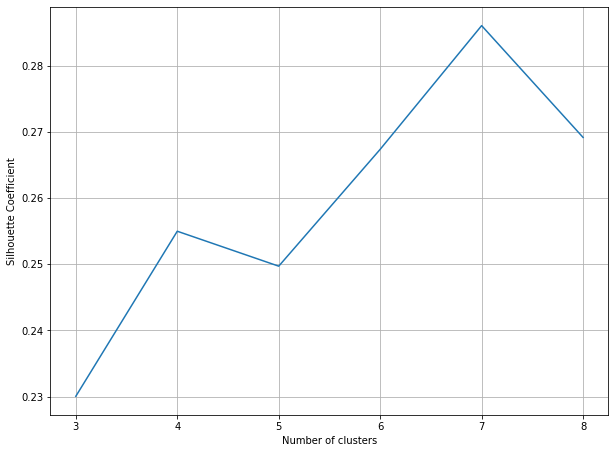

In [227]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Note

The solution can be 6,7 or 8 based on the SC score. If we take highest SC score, 7 segment solution is best

### Segment Distribution

In [234]:
cc_final.cluster_7.value_counts()/sum(cc_final.cluster_7.value_counts())

3    0.240000
4    0.164693
2    0.141676
0    0.131173
6    0.123017
5    0.119553
1    0.079888
Name: cluster_7, dtype: float64

# Profiling

In [235]:
cc_final.cluster_7.value_counts()*100/sum(cc_final.cluster_7.value_counts())

3    24.000000
4    16.469274
2    14.167598
0    13.117318
6    12.301676
5    11.955307
1     7.988827
Name: cluster_7, dtype: float64

In [236]:
pd.Series.sort_index(cc_final.cluster_7.value_counts())

0    1174
1     715
2    1268
3    2148
4    1474
5    1070
6    1101
Name: cluster_7, dtype: int64

In [237]:
size=pd.concat([pd.Series(cc_final.cluster_3.size), pd.Series.sort_index(cc_final.cluster_3.value_counts()), pd.Series.sort_index(cc_final.cluster_4.value_counts()),
           pd.Series.sort_index(cc_final.cluster_5.value_counts()), pd.Series.sort_index(cc_final.cluster_6.value_counts()),
           pd.Series.sort_index(cc_final.cluster_7.value_counts()), pd.Series.sort_index(cc_final.cluster_8.value_counts())])

In [238]:
size

0    8950
0    1593
1    3633
2    3724
0    1570
1    2765
2    1632
3    2983
0    1397
1    1330
2    1435
3    1646
4    3142
0    1425
1    2166
2    1037
3    2122
4    1451
5     749
0    1174
1     715
2    1268
3    2148
4    1474
5    1070
6    1101
0    1003
1    1468
2    1183
3    1433
4    1168
5     713
6     944
7    1038
dtype: int64

In [239]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/cc_final.cluster_3.size, columns=['Seg_Pct'])
Seg_size.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950,1593,3633,3724,1570,2765,1632,2983,1397,1330,...,1070,1101,1003,1468,1183,1433,1168,713,944,1038


In [240]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.177989,0.405922,0.416089,0.175419,0.308939,0.182346,0.333296,0.156089,0.148603,...,0.119553,0.123017,0.112067,0.164022,0.132179,0.160112,0.130503,0.079665,0.105475,0.115978


In [241]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,1593.000000,3633.000000,3724.000000,1570.000000,2765.000000,1632.000000,2983.000000,1397.000000,1330.000000,...,1070.000000,1101.000000,1003.000000,1468.000000,1183.000000,1433.000000,1168.000000,713.000000,944.000000,1038.000000
Seg_Pct,1.0,0.177989,0.405922,0.416089,0.175419,0.308939,0.182346,0.333296,0.156089,0.148603,...,0.119553,0.123017,0.112067,0.164022,0.132179,0.160112,0.130503,0.079665,0.105475,0.115978


In [242]:
cc_final.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,purchase_type_Both,purchase_type_Installment_Purchases,purchase_type_None,purchase_type_One_Of,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0,1,0,0,1,1,3,1,4,1
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,0,0,1,0,2,3,1,2,5,6
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0,0,0,1,2,2,4,4,0,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0,0,0,1,1,2,0,4,0,2
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0,0,0,1,2,2,4,4,0,2


In [243]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([cc_final.apply(lambda x: x.mean()).T, cc_final.groupby('cluster_3').apply(lambda x: x.mean()).T, cc_final.groupby('cluster_4').apply(lambda x: x.mean()).T,
          cc_final.groupby('cluster_5').apply(lambda x: x.mean()).T, cc_final.groupby('cluster_6').apply(lambda x: x.mean()).T,
          cc_final.groupby('cluster_7').apply(lambda x: x.mean()).T, cc_final.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [244]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
BALANCE,1452.399593,1853.934017,234.846316,2468.437917,1858.796123,237.479735,966.629739,2630.404037,132.303115,4008.133548,...,4371.615059,105.545920,2337.937618,637.406278,1264.586431,1942.138167,574.167801,732.238770,4383.601421,104.420802
BALANCE_FREQUENCY,0.883252,0.982238,0.741488,0.979209,0.983332,0.762322,0.821765,0.976310,0.426681,0.967383,...,0.974828,0.393898,0.985632,0.945715,0.952840,0.985726,0.952786,0.789749,0.972523,0.380005
PURCHASES,823.863022,2734.302655,494.812100,327.652405,2717.871944,467.693486,596.977161,281.285913,359.588840,372.026809,...,396.885427,341.867674,3216.553588,559.822860,648.360713,190.818681,1084.370154,414.805412,419.313651,314.994470
ONEOFF_PURCHASES,447.948730,1555.849878,215.168415,201.118535,1534.946131,95.624669,582.273668,128.931569,225.335904,218.599405,...,225.234791,183.256487,1836.059216,0.000000,624.824490,105.675031,609.460738,231.864623,238.385049,168.370850
INSTALLMENTS_PURCHASES,336.336040,983.937032,270.268150,123.767905,999.463986,360.074806,0.000000,149.326941,129.607992,144.028940,...,162.369458,153.816885,1139.937104,526.922446,0.000000,85.143650,463.070242,171.865400,170.408623,141.662652
CASH_ADVANCE,817.161146,452.824134,223.608628,1552.060489,443.555912,227.874656,437.703312,1767.617917,372.926887,3338.100302,...,3500.970658,339.830372,543.505440,161.416251,422.042476,781.038237,239.539725,955.882281,3798.345272,352.628898
PURCHASES_FREQUENCY,0.490351,0.922440,0.514084,0.282363,0.926808,0.585633,0.307400,0.272409,0.278885,0.250139,...,0.266433,0.284975,0.948057,0.753418,0.348485,0.183185,0.694299,0.427432,0.274476,0.271822
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.585647,0.124700,0.114400,0.583445,0.062793,0.307145,0.074121,0.089880,0.105165,...,0.107699,0.071983,0.643647,0.000000,0.348133,0.070207,0.336032,0.123752,0.111834,0.065202
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.734444,0.391428,0.179830,0.750443,0.522077,0.000000,0.214541,0.189008,0.164217,...,0.183032,0.213508,0.789054,0.726509,0.000000,0.138819,0.523084,0.291176,0.185210,0.203701
CASH_ADVANCE_FREQUENCY,0.127637,0.073647,0.040354,0.235883,0.072525,0.041120,0.090985,0.256891,0.048588,0.367211,...,0.374814,0.035569,0.082215,0.034544,0.098161,0.203382,0.059403,0.178148,0.389125,0.036489


In [245]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [246]:
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.000000,1593.000000,3633.000000,3724.000000,1570.000000,2765.000000,1632.000000,2983.000000,1397.000000,1330.000000,...,1070.000000,1101.000000,1003.000000,1468.000000,1183.000000,1433.000000,1168.000000,713.000000,944.000000,1038.000000
Seg_Pct,1.000000,0.177989,0.405922,0.416089,0.175419,0.308939,0.182346,0.333296,0.156089,0.148603,...,0.119553,0.123017,0.112067,0.164022,0.132179,0.160112,0.130503,0.079665,0.105475,0.115978
BALANCE,1452.399593,1853.934017,234.846316,2468.437917,1858.796123,237.479735,966.629739,2630.404037,132.303115,4008.133548,...,4371.615059,105.545920,2337.937618,637.406278,1264.586431,1942.138167,574.167801,732.238770,4383.601421,104.420802
BALANCE_FREQUENCY,0.883252,0.982238,0.741488,0.979209,0.983332,0.762322,0.821765,0.976310,0.426681,0.967383,...,0.974828,0.393898,0.985632,0.945715,0.952840,0.985726,0.952786,0.789749,0.972523,0.380005
PURCHASES,823.863022,2734.302655,494.812100,327.652405,2717.871944,467.693486,596.977161,281.285913,359.588840,372.026809,...,396.885427,341.867674,3216.553588,559.822860,648.360713,190.818681,1084.370154,414.805412,419.313651,314.994470
ONEOFF_PURCHASES,447.948730,1555.849878,215.168415,201.118535,1534.946131,95.624669,582.273668,128.931569,225.335904,218.599405,...,225.234791,183.256487,1836.059216,0.000000,624.824490,105.675031,609.460738,231.864623,238.385049,168.370850
INSTALLMENTS_PURCHASES,336.336040,983.937032,270.268150,123.767905,999.463986,360.074806,0.000000,149.326941,129.607992,144.028940,...,162.369458,153.816885,1139.937104,526.922446,0.000000,85.143650,463.070242,171.865400,170.408623,141.662652
CASH_ADVANCE,817.161146,452.824134,223.608628,1552.060489,443.555912,227.874656,437.703312,1767.617917,372.926887,3338.100302,...,3500.970658,339.830372,543.505440,161.416251,422.042476,781.038237,239.539725,955.882281,3798.345272,352.628898
PURCHASES_FREQUENCY,0.490351,0.922440,0.514084,0.282363,0.926808,0.585633,0.307400,0.272409,0.278885,0.250139,...,0.266433,0.284975,0.948057,0.753418,0.348485,0.183185,0.694299,0.427432,0.274476,0.271822
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.585647,0.124700,0.114400,0.583445,0.062793,0.307145,0.074121,0.089880,0.105165,...,0.107699,0.071983,0.643647,0.000000,0.348133,0.070207,0.336032,0.123752,0.111834,0.065202


In [247]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [248]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,1593.000000,3633.000000,3724.000000,1570.000000,2765.000000,1632.000000,2983.000000,1397.000000,1330.000000,...,1070.000000,1101.000000,1003.000000,1468.000000,1183.000000,1433.000000,1168.000000,713.000000,944.000000,1038.000000
Seg_Pct,1.000000,0.177989,0.405922,0.416089,0.175419,0.308939,0.182346,0.333296,0.156089,0.148603,...,0.119553,0.123017,0.112067,0.164022,0.132179,0.160112,0.130503,0.079665,0.105475,0.115978
BALANCE,1452.399593,1853.934017,234.846316,2468.437917,1858.796123,237.479735,966.629739,2630.404037,132.303115,4008.133548,...,4371.615059,105.545920,2337.937618,637.406278,1264.586431,1942.138167,574.167801,732.238770,4383.601421,104.420802
BALANCE_FREQUENCY,0.883252,0.982238,0.741488,0.979209,0.983332,0.762322,0.821765,0.976310,0.426681,0.967383,...,0.974828,0.393898,0.985632,0.945715,0.952840,0.985726,0.952786,0.789749,0.972523,0.380005
PURCHASES,823.863022,2734.302655,494.812100,327.652405,2717.871944,467.693486,596.977161,281.285913,359.588840,372.026809,...,396.885427,341.867674,3216.553588,559.822860,648.360713,190.818681,1084.370154,414.805412,419.313651,314.994470
ONEOFF_PURCHASES,447.948730,1555.849878,215.168415,201.118535,1534.946131,95.624669,582.273668,128.931569,225.335904,218.599405,...,225.234791,183.256487,1836.059216,0.000000,624.824490,105.675031,609.460738,231.864623,238.385049,168.370850
INSTALLMENTS_PURCHASES,336.336040,983.937032,270.268150,123.767905,999.463986,360.074806,0.000000,149.326941,129.607992,144.028940,...,162.369458,153.816885,1139.937104,526.922446,0.000000,85.143650,463.070242,171.865400,170.408623,141.662652
CASH_ADVANCE,817.161146,452.824134,223.608628,1552.060489,443.555912,227.874656,437.703312,1767.617917,372.926887,3338.100302,...,3500.970658,339.830372,543.505440,161.416251,422.042476,781.038237,239.539725,955.882281,3798.345272,352.628898
PURCHASES_FREQUENCY,0.490351,0.922440,0.514084,0.282363,0.926808,0.585633,0.307400,0.272409,0.278885,0.250139,...,0.266433,0.284975,0.948057,0.753418,0.348485,0.183185,0.694299,0.427432,0.274476,0.271822
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.585647,0.124700,0.114400,0.583445,0.062793,0.307145,0.074121,0.089880,0.105165,...,0.107699,0.071983,0.643647,0.000000,0.348133,0.070207,0.336032,0.123752,0.111834,0.065202


In [249]:
Profling_output_final.to_csv('Profiling_output.csv')